# Image segmentation with camvid



In this notebook, we're going to attempt to perform image segmentation of images taken from a camera mounted on a car, using the dataset Camvid.

For starters, we'll use a smaller dataset with fewer classes.

In [1]:
from fastai import *
from fastai.vision import *
#from fastai.callbacks.hooks import *

In [2]:
path = Path('/home/jupyter/my-datasets/SegNet-Tutorial/CamVid')

In [3]:
path.ls()

[PosixPath('/home/jupyter/my-datasets/SegNet-Tutorial/CamVid/val'),
 PosixPath('/home/jupyter/my-datasets/SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('/home/jupyter/my-datasets/SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('/home/jupyter/my-datasets/SegNet-Tutorial/CamVid/train'),
 PosixPath('/home/jupyter/my-datasets/SegNet-Tutorial/CamVid/testannot'),
 PosixPath('/home/jupyter/my-datasets/SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('/home/jupyter/my-datasets/SegNet-Tutorial/CamVid/valannot'),
 PosixPath('/home/jupyter/my-datasets/SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('/home/jupyter/my-datasets/SegNet-Tutorial/CamVid/test'),
 PosixPath('/home/jupyter/my-datasets/SegNet-Tutorial/CamVid/models')]

Let's look at some images

In [4]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('/home/jupyter/my-datasets/SegNet-Tutorial/CamVid/val/0016E5_08027.png'),
 PosixPath('/home/jupyter/my-datasets/SegNet-Tutorial/CamVid/val/0016E5_08077.png'),
 PosixPath('/home/jupyter/my-datasets/SegNet-Tutorial/CamVid/val/0016E5_08105.png')]

In [5]:
label_names = get_image_files(path/'valannot')
label_names[:3]

[PosixPath('/home/jupyter/my-datasets/SegNet-Tutorial/CamVid/valannot/0016E5_08027.png'),
 PosixPath('/home/jupyter/my-datasets/SegNet-Tutorial/CamVid/valannot/0016E5_08077.png'),
 PosixPath('/home/jupyter/my-datasets/SegNet-Tutorial/CamVid/valannot/0016E5_08105.png')]

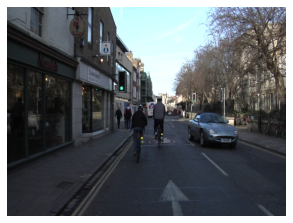

In [6]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [7]:
def get_y_from_path(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

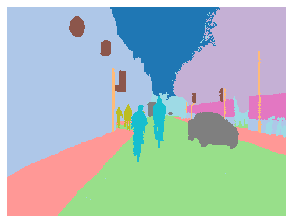

In [8]:
mask = open_mask(get_y_from_path(img_f))
mask.show(figsize=(5,5), alpha=1)

So every pixel has been assigned a label, where the label corresponds to an element of `codes`.

In [9]:
mask.data

tensor([[[1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         ...,
         [4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 3, 3]]])

In [10]:
mask.shape

torch.Size([1, 360, 480])

## Build a databunch

We use the [data_block API](https://docs.fast.ai/data_block.html) from fastai to build a DataBunch.

In [11]:
bs = 8  # batch size

In [12]:
src = (SegmentationItemList.from_folder(path)
                            .split_by_folder(valid='val')
                            .label_from_func(get_y_from_path, classes=codes)
       )

In [13]:
data = (src.transform(get_transforms(), tfm_y=True)
           .databunch(bs=bs)
           .normalize(imagenet_stats)
       )

In [14]:
data

ImageDataBunch;

Train: LabelList (367 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/my-datasets/SegNet-Tutorial/CamVid;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/my-datasets/SegNet-Tutorial/CamVid;

Test: None

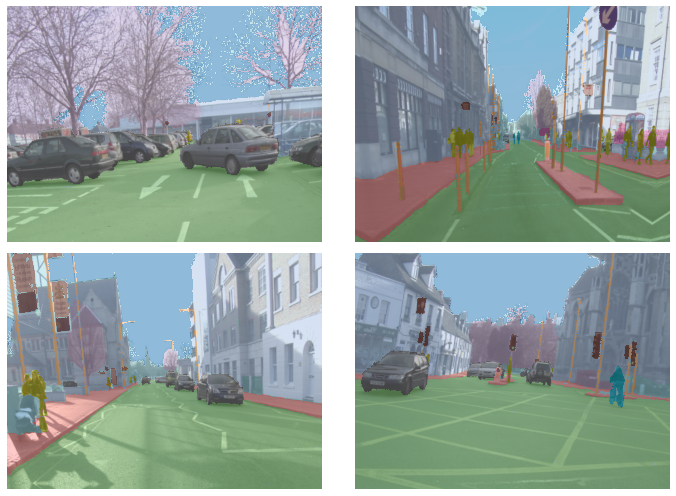

In [15]:
data.show_batch(2, figsize=(10,7))

Nifty that it plots images with the mask on top.

## Train a U-net

In [16]:
name_to_id ={v:k for k,v in enumerate(codes)}

In [17]:
void_code = name_to_id['Void']; void_code

11

In [18]:
def accuracy_camvid(prediction, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (prediction.argmax(dim=1)[mask]==target[mask]).float().mean()

In [19]:
wd = 1e-2  # weight decay (L2 regularization)

In [20]:
learn = unet_learner(data, models.resnet34, metrics=accuracy_camvid, wd=wd, bottle=True)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


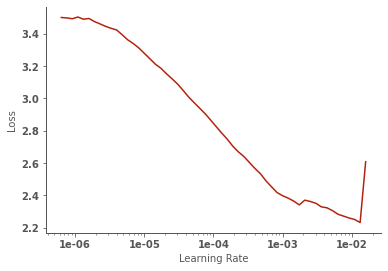

In [42]:
lr_find(learn)
learn.recorder.plot()

In [43]:
lr = 2e-4

In [45]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_camvid,time
0,2.114528,1.771714,0.589645,00:29
1,1.439370,1.065610,0.720647,00:26
2,0.998764,0.646365,0.828131,00:26
3,0.753963,0.570201,0.842784,00:26
4,0.610558,0.530499,0.849043,00:26
5,0.524966,0.445521,0.862821,00:26
6,0.509120,0.433780,0.863537,00:26
7,0.447866,0.349849,0.891585,00:26
8,0.401992,0.337896,0.893015,00:26
9,0.355265,0.321250,0.896591,00:26


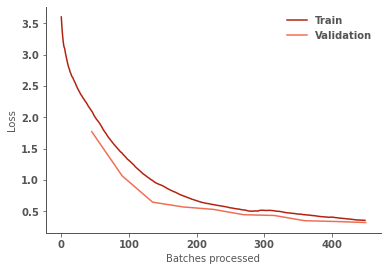

In [47]:
learn.recorder.plot_losses()

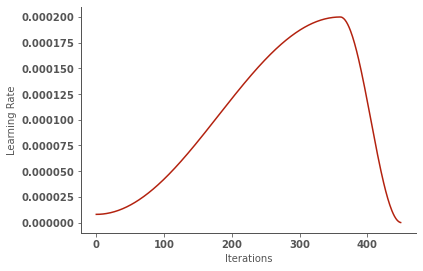

In [49]:
learn.recorder.plot_lr()

Learning rate under 1cycle policy

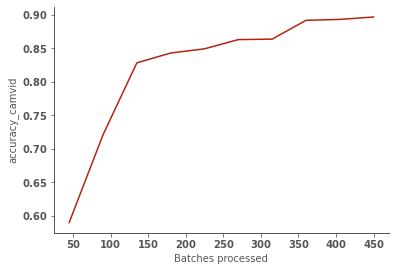

In [50]:
learn.recorder.plot_metrics()

In [51]:
learn.save('stage-1')

In [52]:
learn.load('stage-1');

In [58]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


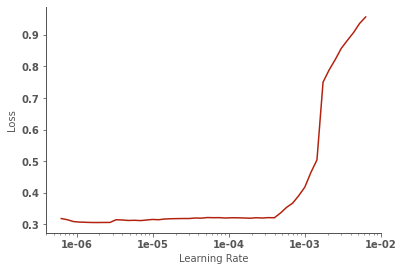

In [59]:
lr_find(learn)
learn.recorder.plot()

In [57]:
lrs = slice(lr/100, lr)

In [61]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_camvid,time
0,0.310864,0.305168,0.902844,00:27
1,0.308738,0.303473,0.903719,00:27
2,0.307757,0.310962,0.899786,00:27
3,0.304925,0.306989,0.902298,00:27
4,0.304319,0.283012,0.909061,00:27
5,0.297840,0.332640,0.897225,00:27
6,0.300666,0.272480,0.918429,00:27
7,0.292587,0.272892,0.922933,00:27
8,0.286196,0.293315,0.918732,00:27
9,0.267073,0.257827,0.923171,00:27


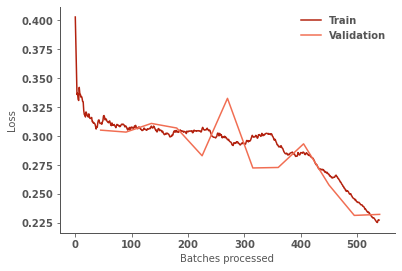

In [62]:
learn.recorder.plot_losses()

In [63]:
learn.save('stage-2')

In [64]:
learn.fit_one_cycle(4, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_camvid,time
0,0.208691,0.233171,0.932141,00:27
1,0.214779,0.260587,0.920412,00:27
2,0.237601,0.313772,0.914873,00:27
3,0.230461,0.246106,0.926495,00:27


That didn't help much, so let's go back.

In [65]:
learn.load('stage-2');

In [69]:
data

ImageDataBunch;

Train: LabelList (367 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/my-datasets/SegNet-Tutorial/CamVid;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/my-datasets/SegNet-Tutorial/CamVid;

Test: None

## Use full-sized images

In [21]:
learn.load('stage-2');

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


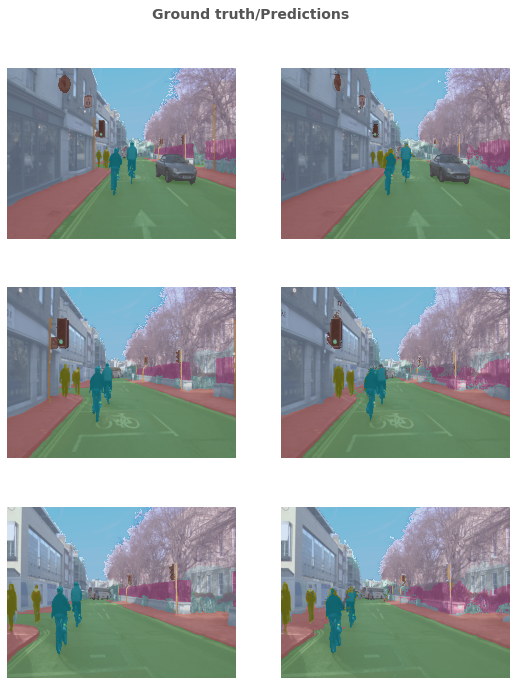

In [22]:
learn.show_results(rows=3, figsize=(9,11))

In [23]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 180, 240]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 180, 240]       128        True      
______________________________________________________________________
ReLU                 [64, 180, 240]       0          False     
______________________________________________________________________
MaxPool2d            [64, 90, 120]        0          False     
______________________________________________________________________
Conv2d               [64, 90, 120]        36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 90, 120]        128        True      
______________________________________________________________________
ReLU                 [64, 90, 120]        0          False     
__________________________________________________

Jeremy also pull a trick where he initially trains on smaller images to learn coarse features, and uses full-sized images for the last bit of training to get an extra couple of % accuracy. I'll leave that for another day -- you get the idea.